# Variational Convolutional Autoencoder

This notebook uses a **Convolutional Variational Autoencoder (CVAE)**.  
It combines the strengths of a **Convolutional Autoencoder**, which captures local spatial patterns in maps, with the **Variational Autoencoder** approach that maps each input to a smooth probability distribution in latent space.  
This way, we compress oceanographic maps into robust, compact representations that stay comparable and regularized.  
Masking handles missing or irrelevant regions, and the structured latent space makes it easier to cluster or analyze similar patterns.



In [70]:
# !pip install cartopy xarray matplotlib netCDF4 torch torchinfo

## Imports

In [2]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, IntSlider

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchinfo import summary

import sys
sys.path.append('/kaggle/input/helper-functions/')
import helper_functions     # Own file.
import importlib
importlib.reload(helper_functions)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Since our ConvNet works with masked map data, it naturally produces some NaNs — that's expected behavior. To avoid flooding the output with warnings, we've disabled them here.

## Data Loading & Preprocessing

In [3]:
# ds = xr.open_dataset("/home/jovyan/spatiotemporal-mining-medsea/data/medsea.nc")
ds = xr.open_dataset("/kaggle/input/thermohaline-structure-of-the-medsea-01062m/medsea_monthly.nc")
print(ds.nbytes / 1e6, "MB")

20554.545012 MB


In [4]:
X_np, M_np = helper_functions.preprocessing_conv(ds, ["thetao", "so"], [50, 300, 1000], 1)
X = torch.tensor(X_np)  # (B, C, H, W)
M = torch.tensor(M_np)
print(X.shape)

torch.Size([342, 6, 203, 514])


Again, we include all depths and features for reconstruction. The difference in our ConvNet is that these features are not simply concatenated, but stacked as channels — similar to how RGB channels work in images. This allows the network to capture spatial relationships between features and depths more effectively, which might be important in our case.

## Splitting

In [14]:
from torch.utils.data import Dataset

class MaskedDataset(Dataset):
    def __init__(self, X, M):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.M[idx]

In [15]:
full_dataset = MaskedDataset(X_np, M_np)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(val_set, batch_size=32)

## The Architecture

In [7]:
class VCAE(nn.Module):
    def __init__(self, in_channels, latent_dim=3, dropout_p=0.1, channels=[32, 64, 128, 256, 512, 1024], input_shape=(203, 514)):
        super().__init__()

        self.input_shape = input_shape
        self.channels = channels

        encoder_layers = []
        prev_channels = in_channels
        h, w = input_shape

        for ch in channels:
            encoder_layers += [
                nn.Conv2d(prev_channels, ch, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(ch),
                nn.LeakyReLU(),
                nn.Dropout2d(p=dropout_p),
            ]
            prev_channels = ch
            h = math.floor((h + 2 * 1 - 3) / 2 + 1)
            w = math.floor((w + 2 * 1 - 3) / 2 + 1)

        self.encoder = nn.Sequential(*encoder_layers)
        self.unflatten_shape = (channels[-1], h, w)

        flat_dim = channels[-1] * h * w
        self.flatten = nn.Flatten()
        self.fc_shared = nn.Sequential(
            nn.Linear(flat_dim, 1024),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(1024, 64),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
        )
        self.fc_mean = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(64, 1024),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(1024, flat_dim)
        )

        decoder_layers = []
        rev_channels = list(reversed(channels))
        for i in range(len(rev_channels) - 1):
            decoder_layers += [
                nn.ConvTranspose2d(rev_channels[i], rev_channels[i + 1], kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(rev_channels[i + 1]),
                nn.LeakyReLU(),
                nn.Dropout2d(p=dropout_p),
            ]

        decoder_layers += [
            nn.ConvTranspose2d(rev_channels[-1], in_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        ]
        self.decoder = nn.Sequential(*decoder_layers)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x, mask=None):
        if mask is not None:
            x = x * mask
        x = self.encoder(x)
        h = self.fc_shared(self.flatten(x))
        z_mean = self.fc_mean(h)
        z_logvar = self.fc_logvar(h)
        z = self.reparameterize(z_mean, z_logvar)
        x = self.fc_dec(z)
        x = x.view(x.size(0), *self.unflatten_shape)
        x = self.decoder(x)
        return x[:, :, :self.input_shape[0], :self.input_shape[1]], z_mean, z_logvar


### Convolutional Autoencoder

We use a simple convolutional autoencoder that compresses the input maps into a small latent vector and reconstructs them back. The encoder reduces spatial resolution through convolutional layers, while the decoder upsamples the data back using transposed convolutions.

I experimented with different numbers of layers, kernel sizes, and dropout values. The current setup gave the best trade-off between reconstruction quality and training stability.


### Hard Masking
- Since many values in the input maps are invalid (e.g. land areas), we apply a **hard mask** before feeding the data into the encoder.
- This mask zeroes out irrelevant values, so the model only learns from valid oceanic regions.
- During training, the same mask is applied to the loss function to ensure the model is not penalized for errors in masked-out areas.
- This is essential for learning robust spatial patterns without being misled by missing or irrelevant data.


## Loss Function

In [8]:
def masked_recon_loss(x_recon, x_true, mask):
    loss = ((x_recon - x_true) ** 2) * mask
    return loss.sum() / mask.sum()

## Training Loop

In [63]:
def train(num_epochs: int, kl_annealing_epochs: int = 50, bint = 100):
    torch.cuda.empty_cache()
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        beta = min(bint, epoch / kl_annealing_epochs * bint)
        model.train()
        running_train_recon = 0.0
        running_train_kl = 0.0

        for x, mask in train_loader:
            x = x.to(device)
            mask = mask.to(device)
            optimizer.zero_grad()
            x_recon, z_mean, z_logvar = model(x, mask=mask)
            kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp(), dim=1).mean()
            recon_loss = masked_recon_loss(x_recon, x, mask)
            loss = recon_loss + beta * kl_loss
            loss.backward()
            optimizer.step()
            running_train_recon += recon_loss.item() * x.size(0)
            running_train_kl += kl_loss.item() * x.size(0)

        train_recon = running_train_recon / len(train_loader.dataset)
        train_kl = running_train_kl / len(train_loader.dataset)
        train_loss = train_recon + beta * train_kl
        train_losses.append(train_loss)

        model.eval()
        running_val_recon = 0.0
        running_val_kl = 0.0

        with torch.no_grad():
            for x, mask in test_loader:
                x = x.to(device)
                mask = mask.to(device)
                x_recon, z_mean, z_logvar = model(x, mask=mask)
                kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp(), dim=1).mean()
                recon_loss = masked_recon_loss(x_recon, x, mask)
                running_val_recon += recon_loss.item() * x.size(0)
                running_val_kl += kl_loss.item() * x.size(0)

        val_recon = running_val_recon / len(test_loader.dataset)
        val_kl = running_val_kl / len(test_loader.dataset)
        val_loss = val_recon + beta * val_kl
        val_losses.append(val_loss)

        if (epoch+1) % 10 == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs} | "
                f"β: {beta:.3f} | "
                f"Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f}) | "
                f"Val Loss: {val_loss:.4f} (Recon: {val_recon:.4f}, KL: {val_kl:.4f})"
            )

    return train_losses, val_losses

## Setup

In [10]:
train_losses = []
val_losses = []

In [61]:
torch.cuda.empty_cache()
# torch.cuda.reset_peak_memory_stats()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VCAE(in_channels=X_np.shape[1], latent_dim=3, dropout_p=0.1, channels= [32, 64, 128, 256, 512, 1024]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

from torchinfo import summary
summary(model, input_size=(1, X_np.shape[1], 203, 514))

Layer (type:depth-idx)                   Output Shape              Param #
VCAE                                     [1, 6, 203, 514]          --
├─Sequential: 1-1                        [1, 1024, 4, 9]           --
│    └─Conv2d: 2-1                       [1, 32, 102, 257]         1,760
│    └─InstanceNorm2d: 2-2               [1, 32, 102, 257]         --
│    └─LeakyReLU: 2-3                    [1, 32, 102, 257]         --
│    └─Dropout2d: 2-4                    [1, 32, 102, 257]         --
│    └─Conv2d: 2-5                       [1, 64, 51, 129]          18,496
│    └─InstanceNorm2d: 2-6               [1, 64, 51, 129]          --
│    └─LeakyReLU: 2-7                    [1, 64, 51, 129]          --
│    └─Dropout2d: 2-8                    [1, 64, 51, 129]          --
│    └─Conv2d: 2-9                       [1, 128, 26, 65]          73,856
│    └─InstanceNorm2d: 2-10              [1, 128, 26, 65]          --
│    └─LeakyReLU: 2-11                   [1, 128, 26, 65]          --
│   

In [65]:
#train_losses, val_losses = train(600, 500, 0.04)
train_losses, val_losses = train(600, 600, 0.06)

Epoch 10/600 | β: 0.001 | Train Loss: 1.0022 (Recon: 1.0022, KL: 0.0085) | Val Loss: 1.0133 (Recon: 1.0133, KL: 0.0021)
Epoch 20/600 | β: 0.002 | Train Loss: 1.0000 (Recon: 1.0000, KL: 0.0045) | Val Loss: 1.0102 (Recon: 1.0102, KL: 0.0009)
Epoch 30/600 | β: 0.003 | Train Loss: 0.9994 (Recon: 0.9994, KL: 0.0051) | Val Loss: 1.0090 (Recon: 1.0090, KL: 0.0050)
Epoch 40/600 | β: 0.004 | Train Loss: 0.9987 (Recon: 0.9976, KL: 0.2931) | Val Loss: 1.0066 (Recon: 1.0050, KL: 0.4125)
Epoch 50/600 | β: 0.005 | Train Loss: 0.9735 (Recon: 0.9678, KL: 1.1545) | Val Loss: 0.9707 (Recon: 0.9675, KL: 0.6416)
Epoch 60/600 | β: 0.006 | Train Loss: 0.8940 (Recon: 0.8797, KL: 2.4335) | Val Loss: 0.8601 (Recon: 0.8468, KL: 2.2553)
Epoch 70/600 | β: 0.007 | Train Loss: 0.8320 (Recon: 0.8121, KL: 2.8765) | Val Loss: 0.8019 (Recon: 0.7793, KL: 3.2799)
Epoch 80/600 | β: 0.008 | Train Loss: 0.7910 (Recon: 0.7661, KL: 3.1525) | Val Loss: 0.7614 (Recon: 0.7380, KL: 2.9615)
Epoch 90/600 | β: 0.009 | Train Loss: 0.

## Evaluation

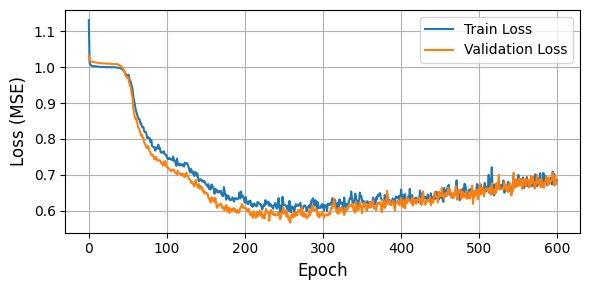

In [67]:
plt.figure(figsize=(6, 3))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

latents_mu = []
latents_logvar = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device).float()
        _, mu, logvar = model(x)
        latents_mu.append(mu.cpu())
        latents_logvar.append(logvar.cpu())

mu_all = torch.cat(latents_mu, dim=0)           # shape: (n_samples, latent_dim)
logvar_all = torch.cat(latents_logvar, dim=0)   # shape: (n_samples, latent_dim)

# Statistics
mu_std = mu_all.std(dim=0)
logvar_mean = logvar_all.mean(dim=0)
logvar_std = logvar_all.std(dim=0)

print("Std of mu per latent dim:")
print(mu_std)

print("\nMean of logvar per latent dim:")
print(logvar_mean)

print("\nStd of logvar per latent dim:")
print(logvar_std)

Std of mu per latent dim:
tensor([0.9486, 0.9860, 0.9004])

Mean of logvar per latent dim:
tensor([-1.9585, -3.0933, -2.0769])

Std of logvar per latent dim:
tensor([0.3847, 0.5349, 0.3697])


In [48]:
def get_latents_and_cluster(model, X, k=9, batch_size=512, device="cpu"):
    """
    Computes the latent means (mu) for all inputs and clusters them using KMeans.
    """

    model.eval()
    model.to(device)

    if isinstance(X, torch.Tensor):
        X_tensor = X
    else:
        X_tensor = torch.tensor(X, dtype=torch.float32)

    X_tensor = X_tensor.to(device)
    latents = []

    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size]

            # VCAE: Encoder + Flatten + fc_shared + fc_mean
            h = model.encoder(batch)
            h = model.fc_shared(model.flatten(h))
            mu = model.fc_mean(h)
            latents.append(mu.cpu())

    latents = torch.cat(latents, dim=0)

    labels = helper_functions.apply_kmeans(latents, k)
    labels += 1

    return latents, labels


In [69]:
torch.save(model.state_dict(), "VCAE.pth")